In [337]:
#Importem tot el necessari:
from pylab import *
from scipy.optimize import curve_fit
%matplotlib inline

## Input parameters:

In [338]:
#BACTERIA:
N = 10000
v0 = 5 #um/s
lam = 1 #s^-1

#BOX (Square simulation box)
L = 400 #um 
#Discretisation for density computation
n = 512
dx = L/n #um 

# Time step in seconds
dt = 0.1 #s

#FEEDBACK PARAMETERS
tau = .2 #s
vfb = 15 #um/s

alpha=10.
#displacement for the feedback
deltax = vfb*tau 
#number of steps that is tau:
m = int(round(tau/dt))

#parameters for the light dependent intensity
vmax=8.
k=0.2
vi=2.

## Classes and methods

In [339]:
class Bacteria:

    def __init__(self, N, v0, lam):
        self.N = N
        self.v0 = v0
        self.lam = lam
        self.pos = zeros((2,N))
        self.vel = ones(N)*v0
        self.theta = random(N)*2*pi
        self.dir = array([cos(self.theta), sin(self.theta)])

    def distribute(self, L):
        self.pos = random((2,N))*L
        
    def distributemiddle(self, L):
        self.pos = random((2,N))*L/4+3*L/8
    
    def evolve(self,dt,light):
        self.v=setspeeds(light,self.pos)
        self.pos += dt*self.v*self.dir
        self.tumble(dt)
        self.boundary(L)
        
    def tumble(self, dt):
        r = random(self.N)
        cond = r<self.lam*dt
        ntumbles = count_nonzero(cond)
        theta = random(ntumbles)*2*pi
        self.theta[cond] = theta
        self.dir[:,cond] = array([cos(theta), sin(theta)])
        
    # PBC    
    def boundary(self, L):
        self.pos[self.pos>L]-=L
        self.pos[self.pos<0]+=L

        
class density:  
    def __init__(self, cells, n, dx):
        self.n = n
        self.dx=dx
        self.counts=zeros((self.n,self.n))    

    def snapshot(self,pos):      
        self.counts,bin_edges,bars=histogram2d(cells.pos[0], cells.pos[1], bins=(n,n))

        

def correlation(rho, rho_old, deltax, alpha):
    #we translate rho old in the x direction by delta x:
    rho_old_tr=roll(rho_old, round(deltax/dx), axis=0)
    light=alpha*rho_old_tr*rho
    return(light)        
     

def setspeeds(light,pos):
    boxx=(pos[0]/dx).astype(int)
    boxy=(pos[1]/dx).astype(int)
    
    v=(vmax-vi)*light[boxx,boxy]/(k+light[boxx,boxy])+vi
    return(v)



### Speed dependence on light intensity

We model it as:
\begin{align}
v(u)=(v_{max}-v_i)\frac{u}{k+u}+v_i
\end{align}

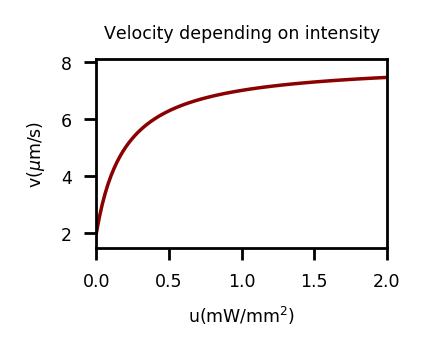

In [340]:
uu=linspace(0,2,100)
v=(vmax-vi)*uu/(k+uu)+vi

mysize=5
fig = plt.figure(figsize=(1.5,1),dpi=250)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=mysize)
plt.title( 'Velocity depending on intensity', fontsize=mysize)            
plt.xlabel('u(mW/mm$^2$)',fontsize=mysize)
plt.ylabel('v($\mu$m/s)',fontsize=mysize)
plt.xlim(right=2,left=0)
plt.ylim(top=8.1,bottom=1.5)

plt.plot(uu,v,linewidth=1,color='darkred')

plt.show()


## Initial configuration

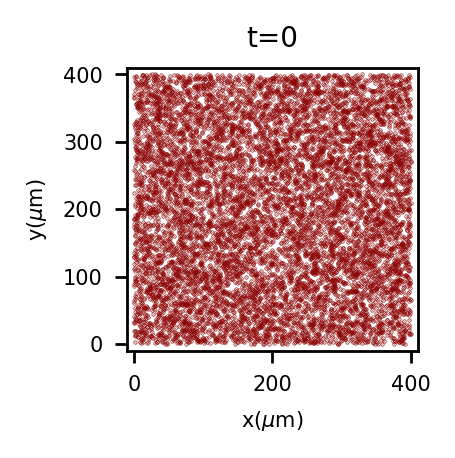

In [341]:
cells = Bacteria(N, v0, lam)
cells.distribute(L)

#-------------------------------------------------------------------------------
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1.5,1.5),dpi=250)
mysize=6
axes.set_title('t=0',fontsize=mysize+2)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)
axes.set_xlim(right=L+10,left=-10)
axes.set_ylim(top=L+10,bottom=-10)
#-------------------------------------------------------------------------------
axes.scatter(cells.pos[0],cells.pos[1],s=0.05, color='darkred', alpha=0.8)
plt.show()

### Evolve over steps

In [342]:
rhos = [zeros((n,n), dtype=float)]*m
steps = 1000

for i in range(steps):
    dens=density(cells, n, dx)
    dens.snapshot(cells.pos)
    rho=dens.counts/(dx*dx)
    
    #we'll translate it deltax in the function correlation
    rho_old = rhos.pop()
    rhos.insert(0, rho)
    
    light = correlation(rho, rho_old, deltax, alpha)
    
    cells.evolve(dt,light)

### Final configuration 

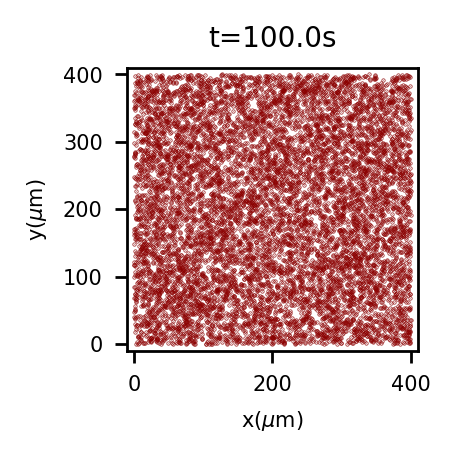

In [343]:
#-------------------------------------------------------------------------------
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1.5,1.5),dpi=250)
mysize=6
axes.set_title('t=' + str(steps*dt) + 's',fontsize=mysize+2)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)
axes.set_xlim(right=L+10,left=-10)
axes.set_ylim(top=L+10,bottom=-10)
#-------------------------------------------------------------------------------
axes.scatter(cells.pos[0],cells.pos[1],s=0.05, color='darkred', alpha=0.8)
plt.show()

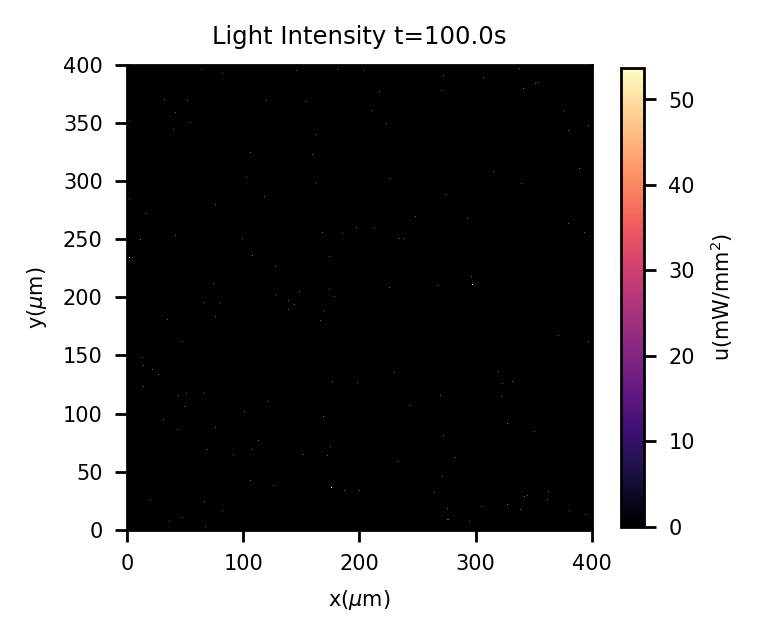

In [344]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3,3),dpi=250)
mysize=6
axes.set_title('Light Intensity t=' + str(steps*dt) + 's',fontsize=mysize+1)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)

imshow(transpose(light), origin='lower',extent=[0,L,0,L],cmap='magma')

cbar=colorbar(shrink=0.81)
cbar.set_label(label='u(mW/mm$^2$)', size=mysize)
cbar.ax.tick_params(labelsize=mysize)

plt.show()

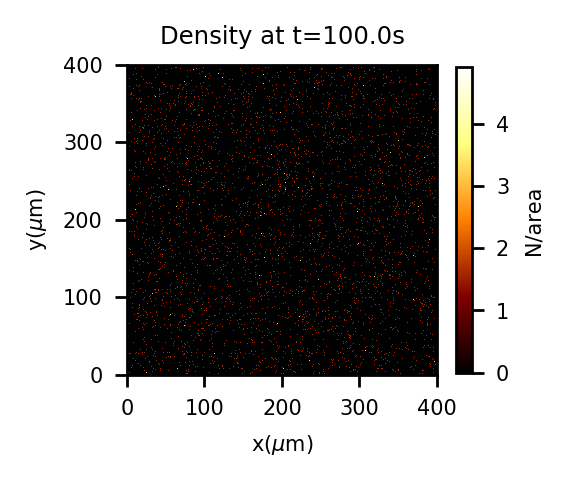

In [345]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2,2),dpi=250)
mysize=6
axes.set_title('Density at t=' + str(steps*dt) + 's',fontsize=mysize+1)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)

imshow(transpose(rho), origin='lower',cmap='afmhot',extent=[0,L,0,L])

cbar=colorbar(shrink=0.81)
cbar.set_label(label='N/area', size=mysize)
cbar.ax.tick_params(labelsize=mysize)

### We change the initial state and put all the bacteria in the center

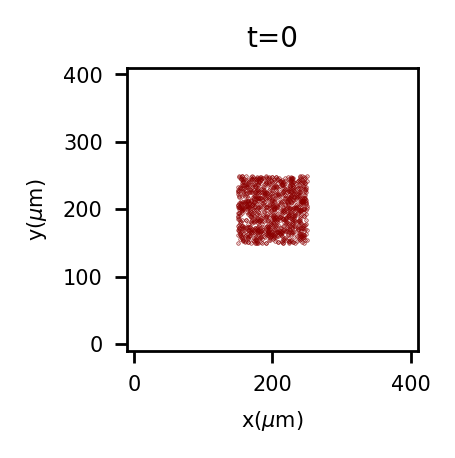

In [346]:
N=1000
cells = Bacteria(N, v0, lam)
cells.distributemiddle(L)

#-------------------------------------------------------------------------------
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1.5,1.5),dpi=250)
mysize=6
axes.set_title('t=0',fontsize=mysize+2)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)
axes.set_xlim(right=L+10,left=-10)
axes.set_ylim(top=L+10,bottom=-10)
#-------------------------------------------------------------------------------
axes.scatter(cells.pos[0],cells.pos[1],s=0.05, color='darkred', alpha=0.8)
plt.show()

### Evolve over steps

In [347]:
rhos = [zeros((n,n), dtype=float)]*m
steps = 2000

for i in range(steps):
    dens=density(cells, n, dx)
    dens.snapshot(cells.pos)
    rho=dens.counts/(dx*dx)
    
    #we'll translate it deltax in the function correlation
    rho_old = rhos.pop()
    rhos.insert(0, rho)
    
    light = correlation(rho, rho_old, deltax, alpha)
    
    cells.evolve(dt,light)

### Final configuration 

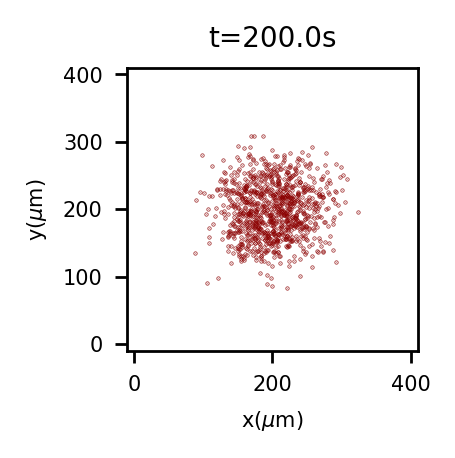

In [348]:
#-------------------------------------------------------------------------------
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1.5,1.5),dpi=250)
mysize=6
axes.set_title('t=' + str(steps*dt) + 's',fontsize=mysize+2)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)
axes.set_xlim(right=L+10,left=-10)
axes.set_ylim(top=L+10,bottom=-10)
#-------------------------------------------------------------------------------
axes.scatter(cells.pos[0],cells.pos[1],s=0.05, color='darkred', alpha=0.8)
plt.show()

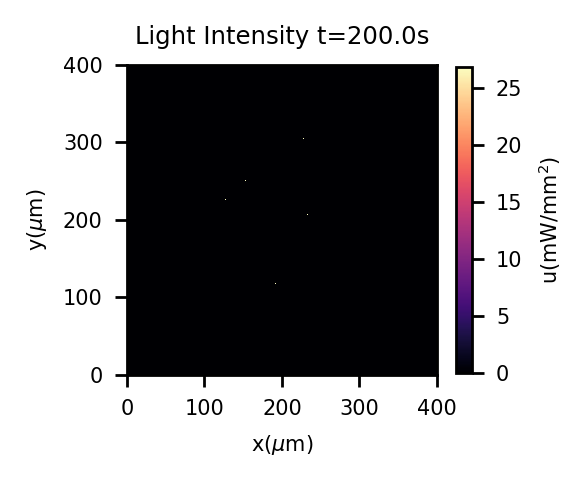

In [349]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2,2),dpi=250)
mysize=6
axes.set_title('Light Intensity t=' + str(steps*dt) + 's',fontsize=mysize+1)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)

imshow(transpose(light), origin='lower',extent=[0,L,0,L],cmap='magma')

cbar=colorbar(shrink=0.81)
cbar.set_label(label='u(mW/mm$^2$)', size=mysize)
cbar.ax.tick_params(labelsize=mysize)

plt.show()

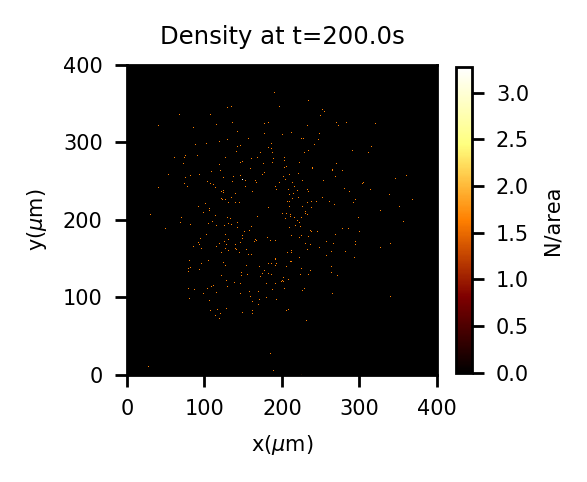

In [351]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2,2),dpi=250)
mysize=6
axes.set_title('Density at t=' + str(steps*dt) + 's',fontsize=mysize+1)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.tick_params(labelsize=mysize)

imshow(transpose(rho), origin='lower',cmap='afmhot',extent=[0,L,0,L])

cbar=colorbar(shrink=0.81)
cbar.set_label(label='N/area', size=mysize)
cbar.ax.tick_params(labelsize=mysize)

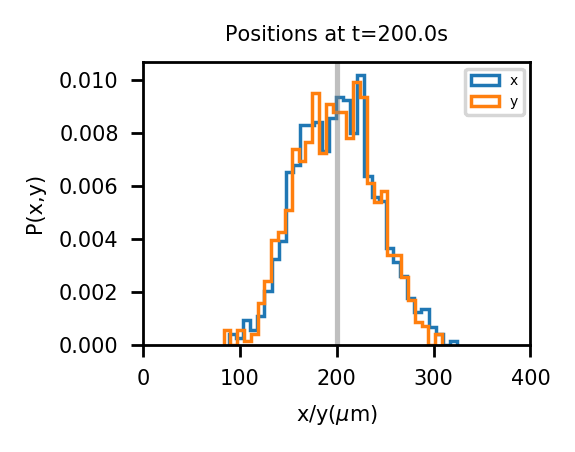

In [352]:
# Histogram positions
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2,1.5),dpi=250)
hist(cells.pos[0], bins=32, label='x',histtype='step', density=True)
hist(cells.pos[1], bins=32, label='y',histtype='step', density=True)
mysize=6
axes.set_title('Positions at t=' + str(steps*dt) + 's',fontsize=mysize)
axes.set_xlabel('x/y($\mu$m)',fontsize=mysize)
axes.set_ylabel('P(x,y)',fontsize=mysize)
axes.tick_params(labelsize=mysize)
axes.set_xlim(right=L,left=0)

plt.legend(fontsize=mysize-2)
plt.axvline(x=200, ymin=0, ymax=1,color='grey',alpha=0.5)
plt.show()
